# ITI110 Project : Energy Consumption Forecasting

Student ID: 22A187U <br>
Name: Carel Teoh Beng Imm

Contents: <br>
> 1. Data Cleaning And Normalization<br>
> 2. Model Building and Training<br>
> 3. Evaluation and Visualization<br>
> 4. Deployment

## Data Preprocessing for Hourly Energy Consumption Dataset (Carel)

In [2]:
# # Clone the tcn repository
# !git clone https://github.com/philipperemy/keras-tcn.git

# # Install the tcn module
# !pip install ./keras-tcn
# from tcn import TCN, tcn_full_summary

In [3]:
import pandas as pd
import numpy as np
import tqdm
import os
import warnings
warnings.filterwarnings('ignore')
# np.random.seed()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

from tcn import TCN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Dense, Input, Lambda
from tensorflow.keras.layers import Conv1D
#from tcn import TemporalConvNet
#from tensorflow.keras.layers import TCN
#from keras_tcn import TCN
#!pip install -q keras-tcn --no-dependencies
from tcn import TCN, tcn_full_summary
import pickle

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
user_folder = '/content/drive/MyDrive/WIP training'

### Load Data For Hourly Dataset

In [6]:
#df = pd.read_csv("2.2 merged_aggregated_hourly_without_block_id.csv")
df = pd.read_csv("/content/drive/MyDrive/WIP training/2.2 merged_aggregated_hourly_without_block_id.csv")


# folder_path = r'C:\Users\Carel\Documents\Course NYP Specialist Diploma in Applied AI PDC2\SDAAI PDC2\ITI110 Project\code file\WIP project'
# csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# os.listdir(folder_path)


In [7]:
df.head()

,date,month,hour,count_LCLid,count_block_id,sum_energy_by_hour,tstp,avg_energy_per_lclid,holiday,visibility,...,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,2011-11-23,11,9,2,2,1.130,2011-11-23 09:00:00,0.565000,0.0,4.39,...,4.84,2011-11-23 09:00:00,4.68,1027.29,3.42,1.78,rain,partly-cloudy-day,0.99,Partly Cloudy
1,2011-11-23,11,10,6,4,1.508,2011-11-23 10:00:00,0.251333,0.0,6.24,...,5.74,2011-11-23 10:00:00,5.46,1027.67,4.24,1.99,rain,partly-cloudy-day,0.98,Partly Cloudy
2,2011-11-23,11,11,7,5,2.123,2011-11-23 11:00:00,0.303286,0.0,10.20,...,7.67,2011-11-23 11:00:00,5.74,1027.56,5.94,2.66,rain,partly-cloudy-day,0.88,Partly Cloudy
3,2011-11-23,11,12,10,7,6.589,2011-11-23 12:00:00,0.658900,0.0,11.62,...,8.84,2011-11-23 12:00:00,6.52,1027.24,7.25,2.80,rain,partly-cloudy-day,0.85,Partly Cloudy
4,2011-11-23,11,13,13,9,6.263,2011-11-23 13:00:00,0.481769,0.0,12.68,...,9.87,2011-11-23 13:00:00,6.99,1027.35,8.29,3.12,rain,partly-cloudy-day,0.82,Mostly Cloudy


In [8]:
df.columns

Index(['date', 'month', 'hour', 'count_LCLid', 'count_block_id',
       'sum_energy_by_hour', 'tstp', 'avg_energy_per_lclid', 'holiday',
       'visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary'],
      dtype='object')

In [9]:
# Initial Overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19864 entries, 0 to 19863
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  19864 non-null  object 
 1   month                 19864 non-null  int64  
 2   hour                  19864 non-null  int64  
 3   count_LCLid           19864 non-null  int64  
 4   count_block_id        19864 non-null  int64  
 5   sum_energy_by_hour    19864 non-null  float64
 6   tstp                  19864 non-null  object 
 7   avg_energy_per_lclid  19864 non-null  float64
 8   holiday               19864 non-null  float64
 9   visibility            19862 non-null  float64
 10  windBearing           19862 non-null  float64
 11  temperature           19862 non-null  float64
 12  time                  19862 non-null  object 
 13  dewPoint              19862 non-null  float64
 14  pressure              19851 non-null  float64
 15  apparentTemperature

In [10]:
# Compute missing values to view actual missing value count for each column
df.isnull().sum()

date                     0
month                    0
hour                     0
count_LCLid              0
count_block_id           0
sum_energy_by_hour       0
tstp                     0
avg_energy_per_lclid     0
holiday                  0
visibility               2
windBearing              2
temperature              2
time                     2
dewPoint                 2
pressure                13
apparentTemperature      2
windSpeed                2
precipType               2
icon                     2
humidity                 2
summary                  2
dtype: int64

#### Drop the category columns

In [11]:
df = df.drop(['precipType', 'icon', 'summary'], axis=1)

In [12]:
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])
df['tstp'] = pd.to_datetime(df['tstp'])


In [13]:
import pandas as pd

# Create a new DataFrame with just the 'date', 'tstp' and 'time'  columns
date_tstp_time_df = df[['date', 'tstp', 'time']]

# Display the new DataFrame
print(date_tstp_time_df)

            date                tstp                time
0     2011-11-23 2011-11-23 09:00:00 2011-11-23 09:00:00
1     2011-11-23 2011-11-23 10:00:00 2011-11-23 10:00:00
2     2011-11-23 2011-11-23 11:00:00 2011-11-23 11:00:00
3     2011-11-23 2011-11-23 12:00:00 2011-11-23 12:00:00
4     2011-11-23 2011-11-23 13:00:00 2011-11-23 13:00:00
...          ...                 ...                 ...
19859 2014-02-27 2014-02-27 20:00:00 2014-02-27 20:00:00
19860 2014-02-27 2014-02-27 21:00:00 2014-02-27 21:00:00
19861 2014-02-27 2014-02-27 22:00:00 2014-02-27 22:00:00
19862 2014-02-27 2014-02-27 23:00:00 2014-02-27 23:00:00
19863 2014-02-28 2014-02-28 00:00:00 2014-02-28 00:00:00

[19864 rows x 3 columns]


In [14]:
# Check if the 'date' and 'time' columns are the same
are_same = (df['tstp'] == df['time']).all()

if are_same:
    print("The 'tstp' and 'time' columns have the same values.")
else:
    print("The 'tstp' and 'time' columns have different values.")


The 'tstp' and 'time' columns have different values.


#### Filter to tstp and time columns to see where the non-matches lie

In [15]:
import pandas as pd

# Filter rows where 'tstp' and 'time' differ
filtered_df = df[df['tstp'] != df['time']]

# Display the differences
filtered_df[['date', 'tstp', 'time']]


,date,tstp,time
15758,2013-09-09,2013-09-09 23:00:00,NaT
15759,2013-09-10,2013-09-10 00:00:00,NaT


#### Notes: Since 'time' column is exact match with 'tstp' column, except for 2 rows: 15758 and 15759. It will not make sense to inpute the dates in these rows, therefore we will drop these rows.

In [16]:
# Drop specific rows from the DataFrame
df = df.drop([15758, 15759])


In [17]:
df.drop(columns=["time"], inplace=True)


In [18]:
df.columns

Index(['date', 'month', 'hour', 'count_LCLid', 'count_block_id',
       'sum_energy_by_hour', 'tstp', 'avg_energy_per_lclid', 'holiday',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity'],
      dtype='object')

In [19]:
df.isnull().sum()

date                     0
month                    0
hour                     0
count_LCLid              0
count_block_id           0
sum_energy_by_hour       0
tstp                     0
avg_energy_per_lclid     0
holiday                  0
visibility               0
windBearing              0
temperature              0
dewPoint                 0
pressure                11
apparentTemperature      0
windSpeed                0
humidity                 0
dtype: int64

#### Identify the missing data from pressure column

In [20]:
missing_pressure = df['pressure'].isnull()

df_missing_pressure = df[missing_pressure]
df_missing_pressure

,date,month,hour,count_LCLid,count_block_id,sum_energy_by_hour,tstp,avg_energy_per_lclid,holiday,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
3993,2012-05-07,5,18,2348,112,1392.479999,2012-05-07 18:00:00,0.593049,0.0,11.27,189.0,12.99,8.29,NaN,12.99,4.22,0.73
8118,2012-10-26,10,15,5494,112,2668.932000,2012-10-26 15:00:00,0.485790,0.0,11.27,21.0,7.29,3.68,NaN,4.21,4.99,0.78
9766,2013-01-03,1,7,5486,112,1993.104000,2013-01-03 07:00:00,0.363307,0.0,9.66,250.0,9.65,8.67,NaN,7.07,5.21,0.94
13540,2013-06-09,6,13,5319,112,2377.313000,2013-06-09 13:00:00,0.446947,0.0,9.98,48.0,13.42,7.76,NaN,13.42,5.07,0.69
14799,2013-08-01,8,0,5268,112,1410.029000,2013-08-01 00:00:00,0.267659,0.0,9.98,193.0,19.16,16.78,NaN,19.38,2.80,0.86
15160,2013-08-16,8,1,5241,112,1152.973000,2013-08-16 01:00:00,0.219991,0.0,9.98,217.0,17.01,14.84,NaN,17.04,3.83,0.87
15398,2013-08-25,8,23,5221,112,1573.785000,2013-08-25 23:00:00,0.301434,0.0,6.39,10.0,17.56,15.49,NaN,17.66,3.75,0.88
15399,2013-08-26,8,0,5227,112,1391.607001,2013-08-26 00:00:00,0.266234,1.0,4.39,358.0,17.02,15.42,NaN,17.13,2.72,0.90
15736,2013-09-09,9,1,5216,112,1095.127000,2013-09-09 01:00:00,0.209955,0.0,9.51,221.0,9.39,8.03,NaN,8.03,2.61,0.91
15739,2013-09-09,9,4,5216,112,1014.337000,2013-09-09 04:00:00,0.194466,0.0,9.46,224.0,9.99,7.72,NaN,9.64,1.51,0.86


In [21]:
df['pressure'] = df['pressure'].fillna(df['pressure'].mean())

# check that it's been filled
# df.isnull().sum()

In [22]:
df.shape

(19862, 17)

In [23]:
df.dtypes

date                    datetime64[ns]
month                            int64
hour                             int64
count_LCLid                      int64
count_block_id                   int64
sum_energy_by_hour             float64
tstp                    datetime64[ns]
avg_energy_per_lclid           float64
holiday                        float64
visibility                     float64
windBearing                    float64
temperature                    float64
dewPoint                       float64
pressure                       float64
apparentTemperature            float64
windSpeed                      float64
humidity                       float64
dtype: object

In [24]:
df.describe()

,month,hour,count_LCLid,count_block_id,sum_energy_by_hour,avg_energy_per_lclid,holiday,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
count,19862.000000,19862.000000,19862.000000,19862.000000,19862.000000,19862.000000,19862.000000,19862.000000,19862.000000,19862.000000,19862.000000,19862.000000,19862.000000,19862.000000,19862.000000
mean,6.411691,11.502819,4206.076528,108.566106,1788.521588,0.436114,0.000906,11.300204,197.666448,10.520699,6.549848,1014.043245,9.263272,3.936179,0.780305
std,3.690227,6.921563,1781.496090,12.272141,1033.232437,0.152784,0.030091,2.963867,90.440553,5.898555,5.133193,11.436290,7.078621,2.045223,0.139798
min,1.000000,0.000000,2.000000,2.000000,1.130000,0.185823,0.000000,0.270000,0.000000,-5.640000,-9.980000,975.740000,-8.880000,0.040000,0.230000
25%,3.000000,6.000000,4064.000000,112.000000,1066.115500,0.325628,0.000000,10.380000,130.000000,6.420000,2.740000,1007.360000,3.770000,2.430000,0.700000
50%,6.000000,12.000000,5106.000000,112.000000,1747.070500,0.420077,0.000000,12.330000,219.000000,9.980000,6.620000,1014.560000,9.735000,3.710000,0.810000
75%,10.000000,18.000000,5337.000000,112.000000,2437.411250,0.522227,0.000000,13.080000,257.000000,14.560000,10.430000,1021.930000,14.560000,5.130000,0.890000
max,12.000000,23.000000,5515.000000,112.000000,5174.705998,0.949662,1.000000,16.090000,359.000000,32.400000,19.880000,1043.320000,32.420000,14.800000,1.000000


In [25]:
# save updated dataset if desired
#df.to_csv('2.2 merged_aggregated_hourly_without_block_id_prepd.csv', index=False)

# Model Building And Training For Temporal Convolutional Network

### Step1 : Splitting the data to prepare for training
### Step2 : Building the TCN model
### Step3 : Train the model
### Step4 : Evaluation and Visualization of the Model

In [26]:
# # Clone the tcn repository
# !git clone https://github.com/philipperemy/keras-tcn.git
# !pip install ./keras-tcn

In [27]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')
np.random.seed(5)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from tcn import TCN
from tensorflow.keras.models import save_model
from tensorflow.keras.layers import Conv1D, Dense, Input, Lambda
from tensorflow.keras.layers import Conv1D
import pickle
import matplotlib.pyplot as plt
import keras

training_run_folder = '/content/drive/MyDrive/WIP training/training_run_folder'

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/WIP training/2.2 merged_aggregated_hourly_without_block_id_prepd.csv')


# Split the data
train_rows = int(len(df) * 0.8)  # 80% train - 20% test
train = df.iloc[:train_rows]
test = df.iloc[train_rows:]

# Check rows
print("dataset no. of rows: ", len(df))
print("train dataset no. of rows: ", len(train))
print("test dataset no. of rows: ", len(test))

# Define target variable
target_variable = 'avg_energy_per_lclid'

# Get the common feature columns for train and test sets
#feature_cols = ['month', 'hour', 'apparentTemperature', 'holiday', 'visibility', 'temperature', 'windBearing', 'dewPoint', 'windSpeed', 'pressure', 'humidity']
feature_cols = ['month', 'hour', 'temperature', 'humidity', 'windSpeed', 'holiday']

# Split the data into features and target variable
X_train = train[feature_cols]
y_train = train[target_variable]
X_test = test[feature_cols]
y_test = test[target_variable]

# Scale the features using MinMaxScaler for normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input data to include a third dimension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# # Define the TCN model WITHOUT residual blocks
# input_shape = (X_train.shape[1], X_train.shape[2])  # Input shape based on the number of features and the additional dimension
# tcn_layer = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=1, padding='causal', activation='relu')
# tcn_model = tf.keras.Sequential([
#     tcn_layer,
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1)  # Output regression
# ])

# Define the TCN model WITH multiple residual blocks
tcn_model = tf.keras.Sequential([
    TCN(nb_filters=64, kernel_size=5, nb_stacks=3, dilations=[1,2], padding='causal', activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),  # Add dropout after each causal convolution
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)  # Output regression
])

# Early stopping implementation using `EarlyStopping` callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Monitor validation loss

# Compile the model
tcn_model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.00001), metrics=[keras.metrics.MeanAbsoluteError()])

callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_run_folder + '/W_ResBlk_7d Run 11/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.2f}-val_MAE-{val_mean_absolute_error:4.2f}-loss-{val_loss:4.2f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]

dataset no. of rows:  19862
train dataset no. of rows:  15889
test dataset no. of rows:  3973


Epoch 1/300
497/497 [==============================] - 16s 23ms/step - loss: 0.7115 - mean_absolute_error: 0.7115 - val_loss: 0.1343 - val_mean_absolute_error: 0.1343
Epoch 2/300
497/497 [==============================] - 10s 20ms/step - loss: 0.4832 - mean_absolute_error: 0.4832 - val_loss: 0.0957 - val_mean_absolute_error: 0.0957
Epoch 3/300
497/497 [==============================] - 10s 19ms/step - loss: 0.3763 - mean_absolute_error: 0.3763 - val_loss: 0.0858 - val_mean_absolute_error: 0.0858
Epoch 4/300
497/497 [==============================] - 11s 21ms/step - loss: 0.3075 - mean_absolute_error: 0.3075 - val_loss: 0.0818 - val_mean_absolute_error: 0.0818
Epoch 5/300
497/497 [==============================] - 11s 21ms/step - loss: 0.2584 - mean_absolute_error: 0.2584 - val_loss: 0.0731 - val_mean_absolute_error: 0.0731
Epoch 6/300
497/497 [==============================] - 9s 18ms/step - loss: 0.2176 - mean_absolute_error: 0.2176 - val_loss: 0.0716 - val_mean_absolute_error: 0.0716

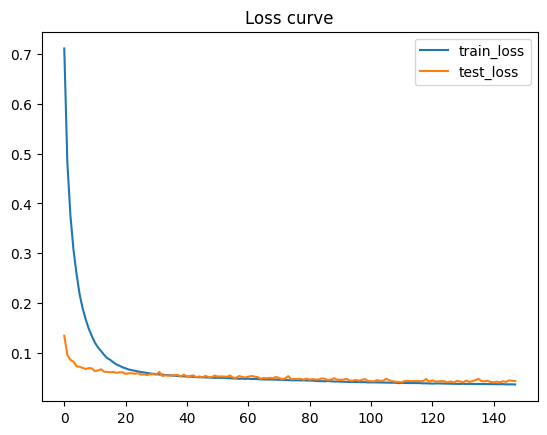

In [28]:
# Train the model
history = tcn_model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks_list)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Loss curve")
plt.legend()
plt.show()



In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15889, 6, 1)
(3973, 6, 1)
(15889,)
(3973,)


In [30]:
# model summary
tcn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 6, 64)             226496    
                                                                 
 dropout (Dropout)           (None, 6, 64)             0         
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 1)                 385       
                                                                 
Total params: 226881 (886.25 KB)
Trainable params: 226881 (886.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Convert the history dictionary to a DataFrame
df_history = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
df_history.to_csv("training_history_TCN_model_woResBlk_Run11.csv", index=False)


# # Save model as .h5 file
tcn_model.save("my_TCN_model_woResBlk_Run11.h5")



In [32]:

# Evaluate the model
loss = tcn_model.evaluate(X_test, y_test)
print("Test Loss:", loss)



125/125 [==============================] - 1s 6ms/step - loss: 0.0432 - mean_absolute_error: 0.0432
Test Loss: [0.04316282272338867, 0.04316282272338867]


In [33]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import math

# Calculate Training MSE
y_pred_train = tcn_model.predict(X_train)
mae_train = mae(y_train, y_pred_train)
print("Train Mean Absolute Error:", mae_train)

y_pred_test = tcn_model.predict(X_test)
mae_test = mae(y_test, y_pred_test)
print("Test Mean Absolute Error:", mae_test)


497/497 [==============================] - 3s 6ms/step
Train Mean Absolute Error: 0.031105256520087457
125/125 [==============================] - 1s 6ms/step
Test Mean Absolute Error: 0.04316283118230124


In [34]:
from sklearn.metrics import mean_absolute_percentage_error as mape
# Calculate Training MAPE
y_pred_train = tcn_model.predict(X_train)
mape_train = mape(y_train, y_pred_train)
print("Train MAPE:", mape_train)

y_pred_test = tcn_model.predict(X_test)
mape = mape(y_test, y_pred_test)
print("Test MAPE:", mape)


497/497 [==============================] - 3s 7ms/step
Train MAPE: 0.07103219179955562
125/125 [==============================] - 1s 9ms/step
Test MAPE: 0.10275182618910557


In [35]:
# Calculate Training RMSE
y_pred_train = tcn_model.predict(X_train)
rmse_train = mse(y_train, y_pred_train, squared=False)  # Avoid squaring again
print("Train RMSE:", rmse_train)

# Calculate Testing RMSE
y_pred_test = tcn_model.predict(X_test)
rmse_test = mse(y_test, y_pred_test, squared=False)
print("Test RMSE:", rmse_test)

497/497 [==============================] - 3s 7ms/step
Train RMSE: 0.043550716172783464
125/125 [==============================] - 1s 6ms/step
Test RMSE: 0.055263153624293314


### Option 1: Save the model using tensoflow keras

In [ ]:
# Saving the model using sklearn
from tensorflow.keras.models import load_model

tcn_model.save('/content/drive/MyDrive/WIP training/saved_models/tcn_model_11.h5')

### Option 2: Save the model with Pickle

In [ ]:
# # Saving model with pickle
# import pickle

# with open('tcn_model_pickle', 'wb') as f:
#   pickle.dump(tcn_model,f)

### Load the saved pickle model

In [ ]:
# # Open model with pickle
# import pickle

# with open('tcn_model_pickle', 'rb') as f:
#   model_tcn = pickle.load(f)

### Option 3: Save the model with joblib

In [ ]:
# # !pip install joblib
# import joblib

# # Save the model with joblib with file name model_joblib.pkl
# tcn_model_joblib = joblib.dump(tcn_model, "tcn_model_joblib.pkl")

### Load the model after saving with joblib

In [ ]:
# # Load the model saved with joblib
# TCN_Model_prediction = joblib.load('model_joblib.pkl')

# Save the model with sklearn version

In [ ]:
# import sklearn

# scikit_ver =sklearn.__version__
# print(scikit_ver)

# # This can be used when saving with pickle or joblib eg:
# joblib.dump(tcn_model, "tcn_model_{version}.pkl".format(version=scikit_ver))

1.2.2


### ~ End of Training and Evaluation ~